
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

##Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

###Import Dataset

In [0]:
# imports
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [0]:
#import file
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00388/data.csv')
print(df.shape)
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

In [4]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    # Three way split using a function I found at 
    #   https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
    #   by user piRSquared

    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, val, test = train_validate_test_split(df, seed=35177)

print(train.shape, val.shape, test.shape)

import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(train,minimal=True)

# profile.to_notebook_iframe()
profile.to_file(output_file='epeleptic_seizure_data_profile.html')

(6900, 180) (2300, 180) (2300, 180)


### Wrangle the data

In [0]:
# defining functions to split the Unnamed: 0 column into something that should 
#  hopefully be useful.
def split_string_X(mystring):
  values = mystring.split('.')
  values = values[0].split('X')
  return values[1]

def split_string_V(mystring):
  values = mystring.split('.')
  values = values[1].split('V')
  return values[1]

def split_string_end(mystring):
  values = mystring.split('.')
  try:
    values[2]
  except:
    return 0
  return values[2]

In [6]:
def wrangle(X):
  X = X.copy()

  # divide "Unamed: 0" into three coulns with the . as the 
  #   seperator
  X['V_id'] = X['Unnamed: 0'].apply(split_string_V)
  X['X_id'] = X['Unnamed: 0'].apply(split_string_X)
  X['data_point'] = X['Unnamed: 0'].apply(split_string_end)
  
  X = X.drop(columns='Unnamed: 0')

  # replace the y with seizure column as the target to
  #  make this a binary classification problem
  X.loc[X['y']==1, 'seizure'] = 1
  X.loc[X['y']!=1, 'seizure'] = 0
  X = X.drop(columns='y')
  
  return X

w_train = wrangle(train)
w_val = wrangle(val)
w_test = wrangle(test)


w_train.shape, w_val.shape, w_test.shape

((6900, 182), (2300, 182), (2300, 182))

In [0]:
target = 'seizure'
features = w_train.drop(columns=target).columns.tolist()

X_train = w_train[features]
y_train = w_train[target]
X_val = w_val[features]
y_val = w_val[target]
X_test = w_test[features]
y_test = w_test[target]

### Use Permutation Importances

In [10]:
# separate the pipeline out  so that we can use the
# Permutation importance
transformers = make_pipeline(
                ce.OrdinalEncoder()
                              )
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(max_depth=10,random_state=7,
                               criterion='entropy')
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=7,
    random_state=7
)

permuter.fit(X_val_transformed,y_val);

In [13]:
# set feature names to a variable
feature_names = X_val.columns.tolist()
# show the weights for each column
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0009 ± 0.0007,X67
0.0007 ± 0.0009,X91
0.0007 ± 0.0004,X133
0.0006 ± 0.0006,X140
0.0006 ± 0.0006,X79
0.0005 ± 0.0007,X86
0.0005 ± 0.0006,X112
0.0005 ± 0.0013,X113
0.0005 ± 0.0009,X16
0.0004 ± 0.0005,X95


In [14]:
# remove all the noise that has an importance of 0 or less
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train[features].shape

(6900, 45)

In [15]:
# Reset all the X matricies to not include the noise
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

print(X_train.shape,X_val.shape,X_test.shape)

(6900, 45) (2300, 45) (2300, 45)


### Run with XGBoost

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

pipeline = make_pipeline(
    XGBClassifier(n_estimators=224, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val,y_pred))
y_pred_proba = pipeline.predict_proba(X_val)[:,-1]
y_pred_proba
print('AUC ROC Score:', roc_auc_score(y_val, y_pred_proba))

Validation Accuracy: 0.9682608695652174
AUC ROC Score: 0.9938790184585139


##Make at least 1 partial dependence plot to explain your model.


In [0]:
#X67, X91, X133


In [0]:
# set up matplotlib for the graphs (double it when using the image for the blog post)
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def graph_pdp(feature):
  
  #set the pipline for the pdp using XGBoost
  pipeline = make_pipeline(
      XGBClassifier(n_estimators=224, random_state=42, n_jobs=-1)
  )
  pipeline.fit(X_train,y_train)

  # set up isolated to use for the plot
  isolated = pdp_isolate(
      model = pipeline,
      dataset=X_val,
      model_features=X_val.columns,
      feature=feature,
      num_grid_points=50
  )

  # plot the pdp
  pdp_plot(isolated, feature_name=feature, plot_lines=True,
          frac_to_plot=.1);
  plt.xlim((-250,250));

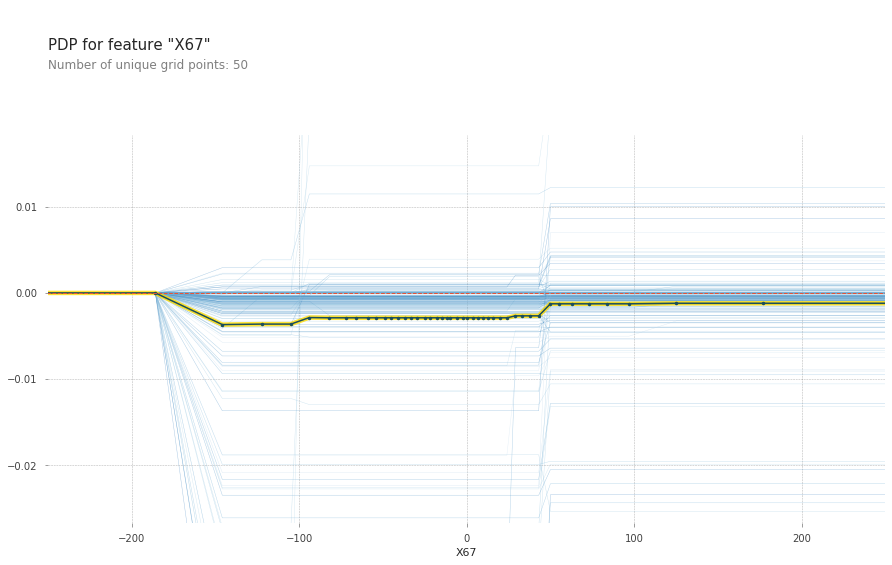

In [34]:
graph_pdp('X67')

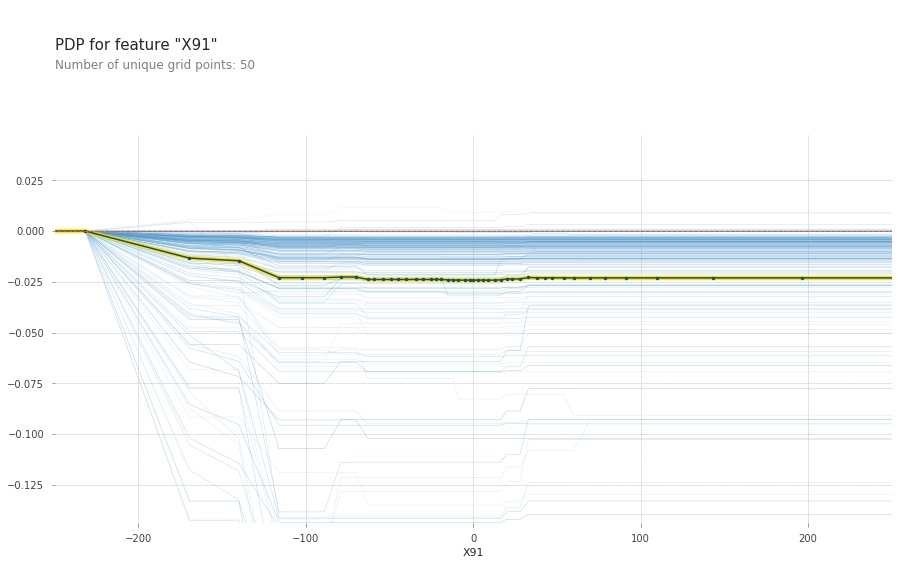

In [35]:
graph_pdp('X91')

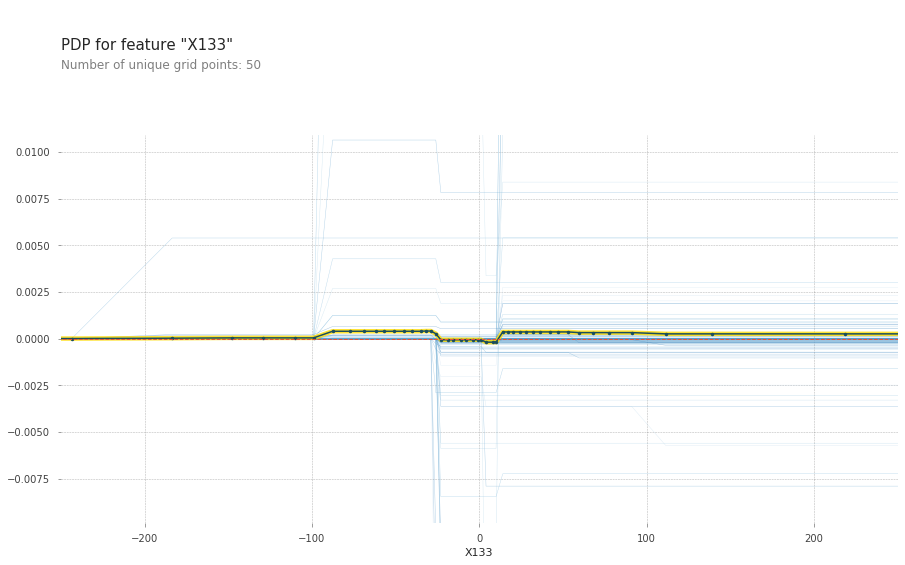

In [36]:
graph_pdp('X133')

##Make at least 1 Shapley force plot to explain an individual prediction


In [0]:
import shap

# set the processor and model to be used in the next cell's function
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]
            
model = XGBClassifier(n_estimators=224, random_state=42, n_jobs=-1)

model.fit(X_train_processed,y_train);

In [0]:
import shap

def explain(row_number):
  positive_class = 1
  positive_class_index = 1

  # Get & process the data for the row
  row = X_test.iloc[[row_number]]
  row_processed = processor.transform(row)

  # Make predictions
  pred = model.predict(row_processed)[0]
  if pred == 1:
    pred = "Having a Seizure"
    positive_class = "Having a Seizure"
  else:
    pred = "Not Having a Seizure"
    positive_class = "Having a Seizure"

  pred_proba = model.predict_proba(row_processed)[0, positive_class_index] 
  pred_proba *= 100
  if pred != positive_class:
    pred_proba = 100 - pred_proba
  
  # show prediction and probability
  print(f'The model predicts this patient is "{pred}" at this point in time, with a {pred_proba:.0f}% probability.')

  # Get shapley additive explanations
  
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(row_processed)

  # Get the top 3 "pros and cons"
  feature_names =row.columns
  feature_values = row.values[0]
  shaps = pd.Series(shap_values[0], zip(feature_names,feature_values))
  pros = shaps.sort_values(ascending=False)[:3].index
  cons = shaps.sort_values(ascending=True)[:3].index

  # Show top 3 reasons for predictions
  print('\nTop 3 reasons for prediction:')
  evidence = pros if pred == positive_class else cons
  for i, info in enumerate(evidence, start=1):
    feature_name, feature_value = info
    print(f'{i}. {feature_name} is {feature_value}.')
  
  # Show top 1 counter-argument against prediction
  print('\nTop counter-argument against prediction:')
  evidence = cons if pred == positive_class else pros
  feature_name, feature_value = evidence[0]
  print(f'- {feature_name} is {feature_value}.')

  # show the shapley values force plot
  shap.initjs()
  return shap.force_plot(
      base_value=explainer.expected_value,
      shap_values=shap_values,
      features=row,
      link='logit' # shows probabilities for classification
  )

In [71]:
X_test.head()

,X1,X12,X16,X20,X27,X39,X53,X54,X57,X58,X61,X63,X66,X67,X68,X70,X71,X79,X86,X91,X92,X93,X95,X112,X113,X114,X123,X124,X128,X133,X135,X138,X140,X145,X151,X152,X153,X154,X156,X157,X165,X166,X171,X174,X175
6342,45,65,156,106,66,-31,17,2,-24,-34,-55,-72,-75,-72,-60,-49,-56,-42,-16,-17,-24,-27,-26,37,32,19,11,4,11,58,60,45,32,50,25,14,27,27,30,26,5,18,0,-1,5
3756,83,5,89,2,-1,-3,19,69,-18,6,30,8,-4,-6,-16,-2,-21,-47,-1,-67,-101,-82,-40,-6,-15,-15,-37,-52,-6,22,28,41,26,-23,-30,-23,-29,-52,-38,-30,-80,-57,-50,-42,-15
4990,-8,17,18,9,39,106,-4,6,9,3,-38,-24,-56,-59,-53,-58,-87,28,195,152,150,130,115,74,61,49,70,49,-12,-53,-27,35,23,46,175,157,123,77,42,39,78,70,23,48,56
8974,-5,-1,-4,-42,-31,26,-12,-18,-22,-12,-11,-21,-39,-40,-37,-45,-51,-35,-11,-30,-22,-21,-20,43,44,44,33,29,13,28,18,-36,-49,-42,-24,-26,-26,-19,-18,-23,-39,-44,-28,-42,-45
56,-1,-98,-73,-7,100,12,12,40,85,80,38,7,-12,-34,-28,-38,-48,-41,-73,-28,-31,-43,-56,-25,-39,-50,19,-25,-25,14,42,-15,0,31,1,-19,-15,-5,30,30,-45,-56,-71,41,38


In [75]:
X_test.shape

(2300, 45)

In [74]:
explain(4)

The model predicts this patient is "Not Having a Seizure" at this point in time, with a 100% probability.

Top 3 reasons for prediction:
1. X39 is 12.
2. X1 is -1.
3. X95 is -56.

Top counter-argument against prediction:
- X57 is 85.


In [77]:
explain(2299)

The model predicts this patient is "Having a Seizure" at this point in time, with a 100% probability.

Top 3 reasons for prediction:
1. X128 is 341.
2. X79 is -373.
3. X12 is 217.

Top counter-argument against prediction:
- X1 is -9.


##Share at least 1 visualization (of any type) on Slack!

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)